In [19]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
        path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

import time
from datetime import timedelta
from pprint import pprint
import corner
import numpy as np
import pickle
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Source Sans Pro']})
# rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Util import data_util
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

from utils import csv_utils

In [20]:
csv_filepath = os.path.join(repo_path, 'data', 'SLACS', 'SLACS.csv')
dataset_dict_list = csv_utils.csv_to_dict_list(csv_filepath)

data_set_name = 'J9EM25AFQ'  # ['J9OP02010', 'J9EM25AFQ', 'J9OP04010', 'J9OP05010', 'J9EM0SEEQ', 'J9OP06010']

oversample_factor = 3

dataset = [d for d in dataset_dict_list if d.get('data_set_name') == data_set_name][0]

target_name = dataset.get('target_name')

# get position
ra, dec = float(dataset.get('ra')), float(dataset.get('dec'))

Load `lenstronomy` model with HST counts

In [21]:
model_array_path = os.path.join(repo_path, 'arrays', 'SLACS', data_set_name + '_hst_counts_' + str(oversample_factor) + '.npy')

lenstronomy = np.load(model_array_path)

# Original Hubble image

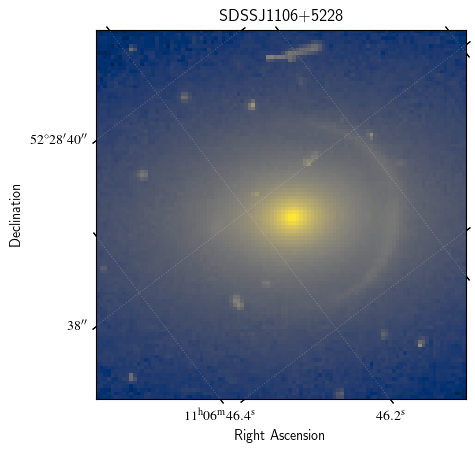

In [22]:
# get original Hubble image
with fits.open(dataset.get('cutout_filepath')) as hdu_list:
    data = hdu_list['PRIMARY'].data
    header = hdu_list['PRIMARY'].header

drizzle_pixel_size = header.get('D001SCAL')

wcs = WCS(header=header)

sky_coords = SkyCoord(ra, dec, unit='deg', frame='icrs')
size = u.Quantity((5, 5), u.arcsec)
cutout_obj = Cutout2D(data, sky_coords, size, wcs=wcs)

# overwrite data and wcs
data = cutout_obj.data
wcs = cutout_obj.wcs

center_pixel_y, center_pixel_x = wcs.all_world2pix(ra, dec, 1, adaptive=False, ra_dec_order=True)

ax = plt.subplot(projection=wcs)
ax.imshow(np.log10(data), cmap='cividis')
plt.grid(color='white', ls=':', alpha=0.2)
# plt.scatter(center_pixel_x, center_pixel_y, edgecolor='red', facecolor='none', s=150, label='Position from MAST')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title(dataset.get('target_name'))
plt.show()

# Pandeia simulation

Load Pandeia simulation

In [23]:
pandeia_array_path = os.path.join(repo_path, 'arrays', 'SLACS', data_set_name + '_pandeia_' + str(oversample_factor) + '.npy')
    
pandeia = np.load(pandeia_array_path)

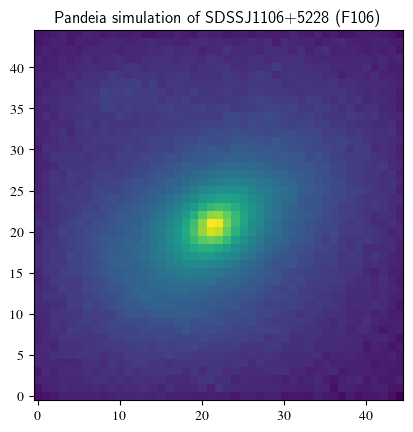

In [24]:
plt.imshow(np.log10(pandeia))
plt.title(f'Pandeia simulation of {target_name} (F106)')
plt.show()

# Mosaic

In [25]:
from PIL import Image
from glob import glob

def combine_images(columns, space, images, filename):
    # calculate number of rows based on columns
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1

    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0

    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width) / 2)
        y_offset = int((height_max-img.height) / 2)
        background.paste(img, (x + x_offset, y + y_offset))
        x += width_max + space

        if (i+1) % columns == 0:
            y += height_max + space
            x = 0

    background.save(filename)

In [28]:
sim_dir = os.path.join(repo_path, 'arrays', 'cnn_training', 'sim')
filename = os.path.join(repo_path, 'cnn_training_mosaic.png')
images = glob(sim_dir + '/*.png')
space = 0
columns = 5

In [29]:
combine_images(columns, space, images, filename)